# Lab09-2

Module Workflow

In [1]:
using Cropbox

## Preparation

Jupyter Notebook is a great tool for prototyping and testing models with interactive simulations. Fiddling with a single system works well and now you have an idea to further expand it to a more complete model. After numerous iterations, now the model becomes a collection of multiple systems, each of which running hundreds of lines of code. Remember our coupled gas exchange model was implemented with more than 20 systems. At this point, coding inside Jupyter Notebook can be no fun anymore. Probably it's a good time to think about organizing your project in a modular way.

Instead of defining systems directly in the notebook, we can put them in a separate text file which can be later loaded by `include()` function. As an example, we have the coupled gas exchange model coded in multiple text files. `gasexchange.jl` is the main entry that includes all other necessary files. Let's go take a look at the files and see how they are organized in the directory (`L09_Model_Synthesis/gasexchange`).

In [2]:
include("gasexchange/gasexchange.jl")

Main.GasExchange

Note that what it returns is not just a single system or variable, but an entire module named `GasExchange`. The module contains lots of systems including ready-to-use composed models like `ModelC3BB` and `ModelC4MD` as we used in Lab06.

In [3]:
GasExchange.ModelC3BB

Main.GasExchange.ModelC3BB

In [4]:
@look GasExchange.ModelC3BB.A_net

[code]
  A_net(Ac, Aj, Ap):net_photosynthesis => begin
            #= /home/jovyan/gasexchange/c3.jl:92 =#
            min(Ac, Aj, Ap)
        end ~ track(u"μmol/m^2/s")


Cropbox provides `look()` function or `@look` macro to show structure of the model with related information like attached docstrings and current values of variables in the case of model instance.

### Module

In Julia, all variables are contained in a [module](https://docs.julialang.org/en/v1/manual/modules/). By default, we're on `Main` module.

In [5]:
a = 1

1

In [6]:
Main.a

1

We can create a new module by using `module .. end` syntax to introduce a separate scope for variables.

In [7]:
module MyModule

a = 2

end

Main.MyModule

In [8]:
MyModule.a

2

In [9]:
Main.a !== MyModule.a

true

## Configurations

As the model definition is served by external files, we can focus on using the model in the notebook. Let's bring up multiple pieces of configurations for some components in the model.

#### C4 Photosynthesis

In [10]:
"Kim et al. (2007), Kim et al. (2006)"
ge_maize1 = :C4 => (
    Vpm25 = 70, Vcm25 = 50, Jm25 = 300,
    Rd25 = 2
)

ge_maize1

In [11]:
"In von Cammerer (2000)"
ge_maize2 = :C4 => (
    Vpm25 = 120, Vcm25 = 60, Jm25 = 400,
)

ge_maize2

In [12]:
"In Kim et al.(2006), under elevated CO2, YY"
ge_maize3 = :C4 => (
    Vpm25 = 91.9, Vcm25 = 71.6, Jm25 = 354.2,
    Rd25 = 2, # Values in Kim (2006) are for 31C, and the values here are normalized for 25C. SK
)

ge_maize3

#### Nitrogen Dependence

In [13]:
"In Sinclair and Horie, Crop Sciences, 1989"
ge_ndep1 = :NitrogenDependence => (s = 4, N0 = 0.2)

ge_ndep1

In [14]:
"In J Vos et al. Field Crop Research, 2005"
ge_ndep2 = :NitrogenDependence => (s = 2.9, N0 = 0.25)

ge_ndep2

In [15]:
"In Lindquist, Weed Science, 2001"
ge_ndep3 = :NitrogenDependence => (s = 3.689, N0 = 0.5)

ge_ndep3

#### Stomatal Conductance

In [16]:
"""
in P. J. Sellers, et al.Science 275, 502 (1997)
g0 is b, of which the value for c4 plant is 0.04
and g1 is m, of which the value for c4 plant is about 4 YY
"""
ge_stomata1 = :StomataBallBerry => (g0 = 0.04, g1 = 4.0)

ge_stomata1

In [17]:
"""
Ball-Berry model parameters from Miner and Bauerle 2017,
used to be 0.04 and 4.0, respectively (2018-09-04: KDY)
"""
ge_stomata2 = :StomataBallBerry => (g0 = 0.017, g1 = 4.53)

ge_stomata2

#### Water Stress

In [18]:
ge_water1 = :StomataTuzet => (
    sf = 2.3, # sensitivity parameter Tuzet et al. 2003 Yang
    ϕf = -1.2, # reference potential Tuzet et al. 2003 Yang
)

:StomataTuzet => (sf = 2.3, ϕf = -1.2)

In [19]:
"switchgrass params from Le et al. (2010)"
ge_water2 = :StomataTuzet => (
    sf = 6.5,
    ϕf = -1.3,
)

ge_water2

#### Weather

In [20]:
ge_weather = :Weather => (
    PFD = 1500,
    CO2 = 400,
    RH = 60,
    T_air = 30,
    wind = 2.0,
);

#### Leaf Nitrogen Relation (SPAD)

In [21]:
ge_spad = :Nitrogen => (
    SNa = 0.0004,
    SNb = 0.0120,
    SNc = 0,
    SPAD = 60,
);

## Simulations

#### Integrated Base

Now we can make a single configuration composed of multiple pieces of configurations depending on our needs.

In [22]:
ge_base = @config(
    ge_weather,
    ge_spad,
    # try use/add alternative configs, for example: ge_maize2, ge_water2, ge_stomata2
    ge_maize1,
    ge_ndep1,
    ge_stomata1,
    ge_water1,
)

Config for 6 systems:
  Weather
    PFD   = 1500
    CO2   = 400
    RH    = 60
    T_air = 30
    wind  = 2.0
  Nitrogen
    SNa  = 0.0004
    SNb  = 0.012
    SNc  = 0
    SPAD = 60
  C4
    Vpm25 = 70
    Vcm25 = 50
    Jm25  = 300
    Rd25  = 2
  NitrogenDependence
    s  = 4
    N0 = 0.2
  StomataBallBerry
    g0 = 0.04
    g1 = 4.0
  StomataTuzet
    sf = 2.3
    ϕf = -1.2

#### Steps for X-axis

In [23]:
ge_step_c = :Weather => :CO2 => 10:10:1500;
ge_step_q = :Weather => :PFD => 0:20:2000;
ge_step_t = :Weather => :T_air => -10:1:50;

#### C3 Medlyn

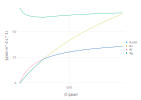

In [24]:
visualize(GasExchange.ModelC3MD, :Ci, [:A_net, :Ac, :Aj, :Ap];
    config = ge_base,
    xstep = ge_step_c,
    kind = :line,
)

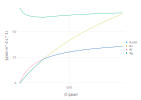

In [25]:
visualize(GasExchange.ModelC3MD, :Ci, [:A_net, :Ac, :Aj, :Ap];
    config = ge_base,
    xstep = ge_step_c,
    kind = :line,
)

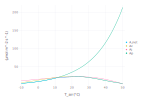

In [26]:
visualize(GasExchange.ModelC3MD, :T_air, [:A_net, :Ac, :Aj, :Ap];
    config = ge_base,
    xstep = ge_step_t,
    kind = :line,
)

#### C4 Medlyn

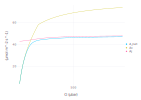

In [27]:
visualize(GasExchange.ModelC4MD, :Ci, [:A_net, :Ac, :Aj];
    config = ge_base,
    xstep = ge_step_c,
    kind = :line,
)

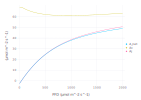

In [28]:
visualize(GasExchange.ModelC4MD, :PFD, [:A_net, :Ac, :Aj];
    config = ge_base,
    xstep = ge_step_q,
    kind = :line,
)

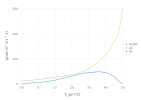

In [29]:
visualize(GasExchange.ModelC4MD, :T_air, [:A_net, :Ac, :Aj];
    config = ge_base,
    xstep = ge_step_t,
    kind = :line,
)

#### Nitrogen vs. Water stress

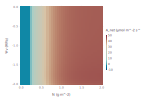

In [30]:
visualize(GasExchange.ModelC4MD, :N, :Ψv, :A_net;
    config = ge_base,
    kind = :heatmap,
    xstep = :Nitrogen => :N => 0:0.05:2,
    ystep = :StomataTuzet => :WP_leaf => -2:0.05:0,
)

## Documentation (bonus)

Julia has a built-in support for [documenting code](https://docs.julialang.org/en/v1/manual/documentation/). As we saw earlier, any string comes before variable declaration or instance itself becomes documentation for the object.

In [31]:
"my value"
a = 1

a

Attached docstrings (documentation string) can be looked up by typing `?` followed by the name of the object.

In [32]:
?a

search: a any all abs ans Any axes atan asin asec any! all! acsc acot acos abs2



my value


In Julia, multiline strings can be made with triple-quotes(`""" .. """`). Note that documentation is interpreted as [Markdown](https://docs.julialang.org/en/v1/stdlib/Markdown/).

In [33]:
"""
### Hello

`b` is *my* **variable**.
"""
b = 2

b

In [34]:
?b

search: b big bind break begin Bool bswap Base BitSet BigInt binomial basename



### Hello

`b` is *my* **variable**.


Cropbox `@system` macro also supports docstrings for any variables declared inside and the system itself.

In [35]:
"My system"
@system S(Controller) begin
    "First variable"
    a => 1 ~ preserve(parameter)
    
    """
    Second variable.
    
    It depends on `a`.
    """
    b(a) => 2a ~ accumulate
end

S

Documentation attached to the system can be looked up by `?` as above.

In [36]:
?S

search: S Sys Set sum sin sec Some sum! step stat sqrt sort skip size sinh sind



My system


Due to internal implementation details, however, documentation for each variable can't be easily accessible using `?`. To alleviate this issue, we can instead use `look()` function to inspect system.

In [37]:
look(S)

[doc]
  My system

[system]
S
  context
  config
  a
  b


`look()` can also inspect a variable.

In [38]:
look(S, :a)

[doc]
  First variable

[code]
  a => 1 ~ preserve(parameter)


Not only the type of system (`S` in this case), but also instance of the system (`s`) can be a target for `look()`. In such case, current value of the variable is displayed together.

In [39]:
s = instance(S)

S
  context = <Context>
  config = <Config>
  a = 1.0
  b = 0.0

In [40]:
look(s, :a)

[doc]
  First variable

[code]
  a => 1 ~ preserve(parameter)

[value]
1.0


As a shortcut, we may want to use `@look` macro for convenience.

In [41]:
@look s.b

[doc]
  Second variable.

  It depends on a.

[code]
  b(a) => 2a ~ accumulate

[value]
0.0
